__Multi-class classification__ vs. __ordinal regression__

<img src="https://www.frontiersin.org/files/Articles/344717/fninf-12-00051-HTML/image_m/fninf-12-00051-g001.jpg">

In [1]:
#!pip install --upgrade https://github.com/HIPS/autograd/archive/master.zip

In [2]:
#!pip install --upgrade https://github.com/fabianp/mord/archive/master.zip

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import norm

In [4]:
dim = 2

X = np.zeros((0,dim))
y = np.zeros((0,))

M = 100

x = np.random.randn(M,2) + np.array([0,4])
X = np.vstack((X, x))
y = np.hstack((y, 1*np.ones(M,)))
x = np.random.randn(M,2) + np.array([4,2])
X = np.vstack((X, x))
y = np.hstack((y, 2*np.ones(M,)))
x = np.random.randn(M,2) + np.array([8,5])
X = np.vstack((X, x))
y = np.hstack((y, 3*np.ones(M,)))
x = np.random.randn(M,2) + np.array([12,3])
X = np.vstack((X, x))
y = np.hstack((y, 4*np.ones(M,)))

In [5]:
print(X.shape, y.shape)

(400, 2) (400,)


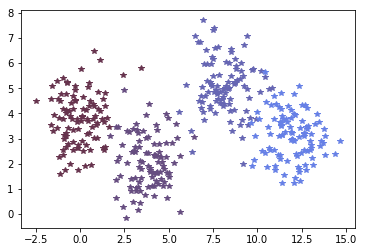

In [6]:
classes = np.unique(y)
for k in classes:
    plt.plot(X[y==k,0], X[y==k,1], marker='*', color=[0.4, 0.1+k*0.1, 0.1+k*0.2], linestyle = 'None')

In [7]:
K = len(classes)

__Ordinal regression__: _all threshold_ (AT) model

http://fa.bianp.net/blog/2013/loss-functions-for-ordinal-regression/

In [8]:
def predict_ordinal_AT(theta, X):
    dim = X.shape[1]
    w = theta[:dim]
    thresholds = theta[dim:]
    score = np.dot(X,w)
    H = score[:,np.newaxis] > thresholds[np.newaxis,:]
    r = 1 + np.sum(H, axis=1)
    return r

Accuracy: 0.960
[[0.98 0.02 0.   0.  ]
 [0.01 0.98 0.01 0.  ]
 [0.   0.02 0.93 0.05]
 [0.   0.   0.05 0.95]]


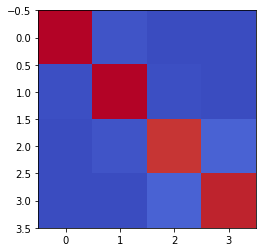

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

w = np.array([1,0])*7.777
thresholds = np.array([2,6,10])*7.777
theta = np.hstack((w, thresholds))

y_pred = predict_ordinal_AT(theta, X)

acc = accuracy_score(y, y_pred)
print("Accuracy: %0.3f" % (acc))

confmat = confusion_matrix(y, y_pred)
confmat = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
print(confmat)
plt.imshow(confmat, cmap=plt.cm.get_cmap('coolwarm'))
plt.show()

In [27]:
import mord

clf = mord.LogisticAT(alpha=1.)
clf.fit(X, y.astype('int'))
y_pred = clf.predict(X)

acc = accuracy_score(y, y_pred)
print("Accuracy: %0.3f" % (acc))

w = clf.coef_
thresholds = clf.theta_

print(w/norm(w))
print(thresholds/norm(w))

Accuracy: 0.963
[ 0.98991954 -0.14163085]
[1.4475667  5.34311014 9.38376786]


In [11]:
import autograd.numpy as anp

def softplus(x): # = log(1 + exp(x))
    lt_34 = (x >= 34)
    gt_n37 = (x <= -36.8)
    neither_nor = anp.logical_not(anp.logical_or(lt_34, gt_n37))
    rval = anp.where(gt_n37, 0., anp.log(1 + anp.exp(x)))
    rval = anp.where(lt_34, x, rval)    
    return rval

def log_loss(x):
    return softplus(-x)

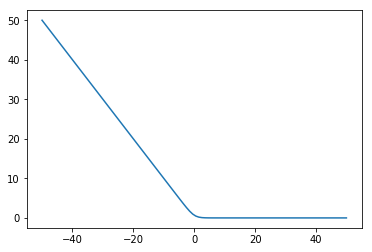

In [12]:
t = np.linspace(-50,50,100)
plt.plot(t, log_loss(t))

In [13]:
def _risk_ordinal(theta, X, y, beta):
    dim = X.shape[1]
    K = int(np.max(y))
    w = theta[:dim]
    thresholds = theta[dim:]
    score = anp.dot(X,w)
    signs = 2.*(y[:,np.newaxis] <= np.arange(1,K)[np.newaxis,:]) - 1
    S = thresholds[anp.newaxis,:] - score[:,anp.newaxis]
    regularizer = 0.5*beta*anp.dot(theta, theta)
    risk = anp.mean(anp.sum(log_loss(S*signs), axis=1)) 
    return risk + regularizer

In [14]:
from autograd.misc.optimizers import adam
from scipy.optimize import minimize
from autograd import grad

def fit_ordinal_AT(X, y, beta=0.001, method=None):
    dim = X.shape[1]
    classes = np.unique(y)
    K = len(classes)
    
    if method is None:
        if (dim+K) > 1e+4:
            method = 'gradient'
        else:
            method = 'LBFGS'
    
    params_init = np.random.randn(dim+K-1)
    
    if method == 'gradient':
        objective = lambda params, i: _risk_ordinal(params, X, y, beta)
        gradient = grad(objective)      
        params_opt = adam(gradient, params_init, num_iters=1000, step_size=0.001)
    elif method == 'LBFGS':       
        objective = lambda params: _risk_ordinal(params, X, y, beta)
        gradient = grad(objective)
        result = minimize(objective, params_init, method='L-BFGS-B', jac=gradient, options={'gtol': 1e-5, 'disp': True}) 
        params_opt = result.x
    else:
        print('Wrong optimization method!')
        params_opt = params_init
    
    return params_opt

In [28]:
theta_opt = fit_ordinal_AT(X, y, beta=0.0)

y_pred = predict_ordinal_AT(theta_opt, X)

acc = accuracy_score(y, y_pred)
print("Accuracy: %0.3f" % (acc))

w = theta_opt[:dim]
thresholds = theta_opt[dim:]
print(w/norm(w))
print(thresholds/norm(w))

Accuracy: 0.965
[ 0.98791325 -0.15500777]
[1.40281547 5.27838304 9.31309137]


__Multi-class classification__: _softmax regression_

In [19]:
from autograd.scipy.misc import logsumexp

def predict_softmax(theta, X, K, return_log_probs=False):
    dim = X.shape[1]
    W = theta[:K*dim].reshape((K,dim))
    b = theta[K*dim:]
    scores = anp.dot(X, W.T) + b.T
    if return_log_probs:
        log_prob = scores - logsumexp(scores, axis=1, keepdims=True)
        #prob = anp.exp(log_prob)
        return y, log_prob
    else:
        return np.argmax(scores, axis=1) + 1 # !!!

def _risk_softmax(theta, X, Y, beta):
    dim = X.shape[1]
    K = int(np.max(y))
    _, log_prob = predict_softmax(theta, X, K, return_log_probs=True)
    regularizer = 0.5*beta*anp.dot(theta, theta)
    risk = (-1.)*anp.mean(anp.sum(log_prob * Y, axis=1))
    return risk + regularizer

In [20]:
from sklearn.preprocessing import LabelBinarizer

def fit_softmax(X, y, beta=0.001, method=None):
    dim = X.shape[1]
    classes = np.unique(y)
    K = len(classes)
    
    if method is None:
        if (K*dim+K) > 1e+4:
            method = 'gradient'
        else:
            method = 'LBFGS'  

    lb = LabelBinarizer()
    Y = lb.fit_transform(y)
    
    params_init = np.random.randn(K*dim+K)
    
    if method == 'gradient':
        objective = lambda params, i: _risk_softmax(params, X, Y, beta)
        gradient = grad(objective)      
        params_opt = adam(gradient, params_init, num_iters=1000, step_size=0.001)
    elif method == 'LBFGS':       
        objective = lambda params: _risk_softmax(params, X, Y, beta)
        gradient = grad(objective)
        result = minimize(objective, params_init, method='L-BFGS-B', jac=gradient, options={'gtol': 1e-5, 'disp': True}) 
        params_opt = result.x
    else:
        print('Wrong optimization method!')
        params_opt = params_init
    
    return params_opt

In [26]:
theta_opt = fit_softmax(X, y, beta=0.0)

y_pred = predict_softmax_(theta_opt, X, K)

acc = accuracy_score(y, y_pred)
print("Accuracy: %0.3f" % (acc))

Accuracy: 0.973
